In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE, SelectFromModel

In [3]:
data = pd.read_csv("./ad-dataset/ad.data", header=None)
data.rename(columns={0: 'height',
                    1: 'width',
                    2: 'ratio(width/height)',
                    3: 'local',
                    1558: 'y'}, inplace=True)

C:\Users\batuhan.organ\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Replace categoricals with numerical
data['y'].replace(('ad.', 'nonad.'), (1, 0), inplace=True)

In [5]:
# Remove whitespace from the columns
for col in data.columns:
    if data[col].dtypes == 'O':
        data[col] = data[col].str.replace(" ","")

In [6]:
# Replace ? with nan
data = data.replace('?', np.nan)

In [7]:
# Change datatypes
data = data.astype({"height": float, "width": float,
                    "ratio(width/height)": float, 'local': float})

In [8]:
# Dist of Prediction
data.y.value_counts()

0    2820
1     459
Name: y, dtype: int64

In [9]:
df = pd.DataFrame()

for col in data.columns:
    df.at[col, 'Na Percent'] = (data[col].isna().sum()/len(data))*100
df.reset_index(inplace=True)
df['Na Percent'].sort_values()

779      0.000000
1044     0.000000
1043     0.000000
1042     0.000000
1041     0.000000
          ...    
523      0.000000
1       27.477890
0       27.538884
2       27.752364
3       37.999390
Name: Na Percent, Length: 1559, dtype: float64

This shows that first 4 columns are almost 30-40 percent na, we need to deal with them.

In [10]:
data['local'].value_counts()

1.0    1578
0.0     455
Name: local, dtype: int64

In [11]:
# Replace nan with mean, for binary column replace with 1 since it is the most recurring element
data['height'].fillna(data['height'].mean(), inplace=True)
data['width'].fillna(data['width'].mean(), inplace=True)
data['ratio(width/height)'].fillna(data['ratio(width/height)'].mean(), inplace=True)
data['local'].fillna(1, inplace=True)

print("Before na drop: ", data.shape)
data.dropna(inplace=True)
print("After na drop: ", data.shape)

Before na drop:  (3279, 1559)
After na drop:  (3279, 1559)


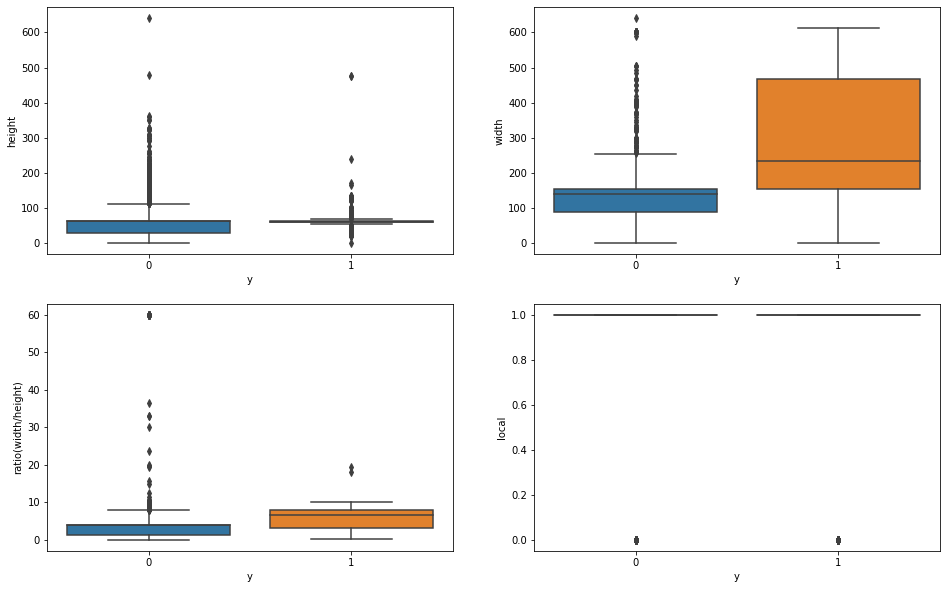

In [12]:
# Plot continuous plots since except the first 4 features, rest is url features
plot_num = 0
columns_to_plot = ['height', 'width', 'ratio(width/height)', 'local']
fig, axarr=plt.subplots(2, 2, figsize=(16,10))
for i in range(2):
        for j in range(2):
            sns.boxplot(x='y', y=columns_to_plot[plot_num], data=data, ax=axarr[i][j])
            plot_num+=1

Width seems to be differs more than the others with respect to y value.

I will try 5 scenarios (3 for the assignment, 2 for extra), firstly with all features, secondly with largest 10 features, thirdly, according to 80-20 rule, first n features which reaches the 80% of cumulative rank scores, fourthly with select from model, lastly with recursive feature selection  

In [13]:
seed = 110
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df_list = list(df.columns)

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state = seed)

print ("Train_x Shape: ",train_x.shape)
print ("Train_y Shape: ", train_y.shape)
print ("Test_x Shape: ", test_x.shape)
print ("Test_y Shape: ", test_y.shape)

Train_x Shape:  (2295, 1558)
Train_y Shape:  (2295,)
Test_x Shape:  (984, 1558)
Test_y Shape:  (984,)


In [14]:
def get_models():
    
    dt = DecisionTreeClassifier(random_state=seed)
    sgb = GradientBoostingClassifier(random_state=seed)
    rf = RandomForestClassifier()
    clf = BaggingClassifier(base_estimator=SVC(), n_estimators=100, random_state=seed)
    nb = GaussianNB()
    svc = SVC(C=10, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    
    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'gradient boosting': sgb,
              'random forest': rf,
              'decision tree': dt,
              'bagging': clf
              }

    return models


def prediction(model_list):
    
    pred = np.zeros((test_y.shape[0], len(model_list)))
    pred = pd.DataFrame(pred)

    print("Calculating predictions..")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("Model: %s" % name)
        m.fit(train_x, train_y)
        pred.iloc[:, i] = m.predict_proba(test_x)[:, 1]
        cols.append(name)
        
    pred.columns = cols
    return pred


def roc_auc_func(y, pred, scenario):
    roc_scores = pd.DataFrame()
    print("Calculating roc auc scores..")
    for i in pred.columns:
        score = roc_auc_score(y, pred.loc[:, i])
        roc_scores.at[i, scenario] = score
        print("%-26s: %.3f" % (i, score))
    roc_scores.reset_index(inplace=True)
    return roc_scores


models = get_models()
pred = prediction(models)
roc_scores = roc_auc_func(test_y, pred, scenario=1)

Calculating predictions..
Model: svm
Model: knn
Model: naive bayes
Model: gradient boosting
Model: random forest
Model: decision tree
Model: bagging
Calculating roc auc scores..
svm                       : 0.972
knn                       : 0.922
naive bayes               : 0.844
gradient boosting         : 0.961
random forest             : 0.980
decision tree             : 0.914
bagging                   : 0.740


Scenario 1 was testing models with all features. It shows that except bagging, all the models performed pretty good, especially random forest, svm and gradient boosting over 96%. 

Now Scenario 2.. Using only 10 best features.

In [15]:
x = data.iloc[:, 0:len(data.iloc[0])-1]  #independent columns
y = data.iloc[:, -1]  # dependent columns

topfeatures = SelectKBest(score_func=chi2, k=10)
fit = topfeatures.fit(x,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x.columns)

feature_rank = pd.concat([df_columns, df_scores], axis=1)
feature_rank.columns = ['Specs','Score'] 
print(feature_rank.nlargest(10,'Score'))

      Specs         Score
1     width  69019.134582
1243   1243   1027.589802
351     351    850.098061
1399   1399    814.710084
1483   1483    624.539011
968     968    616.175471
1344   1344    604.557879
1455   1455    598.476130
1435   1435    576.648267
1143   1143    524.735193


In [16]:
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df = df[feature_rank.nlargest(10, 'Score').Specs.tolist()]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state = seed)

print ("Train_x Shape: ",train_x.shape)
print ("Train_y Shape: ", train_y.shape)
print ("Test_x Shape: ", test_x.shape)
print ("Test_y Shape: ", test_y.shape)

Train_x Shape:  (2295, 10)
Train_y Shape:  (2295,)
Test_x Shape:  (984, 10)
Test_y Shape:  (984,)


In [17]:
models = get_models()
pred = prediction(models)
roc_scores1 = roc_auc_func(test_y, pred, scenario=2)

Calculating predictions..
Model: svm
Model: knn
Model: naive bayes
Model: gradient boosting
Model: random forest
Model: decision tree
Model: bagging
Calculating roc auc scores..
svm                       : 0.910
knn                       : 0.893
naive bayes               : 0.916
gradient boosting         : 0.947
random forest             : 0.941
decision tree             : 0.909
bagging                   : 0.737


In [18]:
roc_scores = pd.merge(roc_scores, roc_scores1, on='index')

In [19]:
roc_scores['Improvement'] = ((roc_scores[2] - roc_scores[1])/roc_scores[1]) * 100
roc_scores

,index,1,2,Improvement
0,svm,0.971601,0.910236,-6.315826
1,knn,0.922493,0.893137,-3.182317
2,naive bayes,0.844452,0.915844,8.454331
3,gradient boosting,0.960954,0.946920,-1.460458
4,random forest,0.980057,0.940680,-4.017768
5,decision tree,0.914163,0.908990,-0.565869
6,bagging,0.740382,0.736605,-0.510037


Selecting top 10 best features do not improve our model scores except naive bayes, this shows that we should include more features.

Now Scenario 3.. Using best features which cumulative sum of their rankings reach to 80%.

In [20]:
feature_rank = feature_rank.sort_values(by=['Score'], ascending=False)
feature_rank.reset_index(inplace=True)
feature_rank = feature_rank.drop('index', 1)

feature_rank['cumulative_percentage'] = 100 * feature_rank.Score.cumsum()/feature_rank.Score.sum()
max_features = feature_rank.loc[feature_rank['cumulative_percentage'] <= 80]
print("We can select top", len(max_features), "features which reach the 80%")

labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df = df[max_features.Specs.tolist()]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state=seed)

models = get_models()
pred = prediction(models)
roc_scores3 = roc_auc_func(test_y, pred, scenario=3)

roc_scores = pd.merge(roc_scores[['index', 1, 2]], roc_scores3, on='index')
roc_scores['Improvement'] = ((roc_scores[3] - roc_scores[1])/roc_scores[1]) * 100
roc_scores

We can select top 88 features which reach the 80%
Calculating predictions..
Model: svm
Model: knn
Model: naive bayes
Model: gradient boosting
Model: random forest
Model: decision tree
Model: bagging
Calculating roc auc scores..
svm                       : 0.943
knn                       : 0.909
naive bayes               : 0.942
gradient boosting         : 0.953
random forest             : 0.971
decision tree             : 0.929
bagging                   : 0.737


,index,1,2,3,Improvement
0,svm,0.971601,0.910236,0.942566,-2.988332
1,knn,0.922493,0.893137,0.909187,-1.442469
2,naive bayes,0.844452,0.915844,0.942211,11.576669
3,gradient boosting,0.960954,0.946920,0.952992,-0.828579
4,random forest,0.980057,0.940680,0.971020,-0.922090
5,decision tree,0.914163,0.908990,0.928620,1.581413
6,bagging,0.740382,0.736605,0.736660,-0.502694


Selecting top 88 best features improved only naive bayes and decision tree with respect to initial. However, almost all the methods' scores improved with respect to 2. scenario(using top 10 features). This proves that we should include more features.

Now Scenario 4.. Using select from model as feature selection. Also, we select the 3 model for further analysis, this means that we select Random Forest, Gradient Boosting and Decision Tree

Select From Model

In [22]:
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)
df_list = list(df.columns)

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state = seed)

# Random Forest
rf = RandomForestClassifier()
sfm = SelectFromModel(rf)
sfm.fit(train_x, train_y)

feature_list_rf = []
for i in range(len(data.columns.tolist())):
    if i in sfm.get_support(indices=True):
        feature_list_rf.append(data.columns.tolist()[i])
        
# Decision Tree
dt = DecisionTreeClassifier(random_state=seed)
sfm_dt = SelectFromModel(dt)
sfm_dt.fit(train_x, train_y)

feature_list_dt = []
for i in range(len(data.columns.tolist())):
    if i in sfm_dt.get_support(indices=True):
        feature_list_dt.append(data.columns.tolist()[i])

# Gradient Boosting
sgb = GradientBoostingClassifier(random_state=seed)
sfm_sgb = SelectFromModel(sgb)
sfm_sgb.fit(train_x, train_y)

feature_list_sgb = []
for i in range(len(data.columns.tolist())):
    if i in sfm_sgb.get_support(indices=True):
        feature_list_sgb.append(data.columns.tolist()[i])

In [23]:
print('Number of features for Random Forest are:', len(feature_list_rf))
print('Number of features for Decision Tree are:', len(feature_list_dt))
print('Number of features for Gradient Boosting are:', len(feature_list_sgb))

Number of features for Random Forest are: 240
Number of features for Decision Tree are: 46
Number of features for Gradient Boosting are: 66


Random Forest

In [31]:
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df = df[feature_list_rf]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state=seed)

rf = RandomForestClassifier()
rf.fit(train_x, train_y)
pred = rf.predict_proba(test_x)[:, 1]
rf_sfm_roc_auc = roc_auc_score(test_y, pred)
print("Roc Auc for Random Forest:",rf_sfm_roc_auc)
roc_scores.loc[roc_scores['index'] == 'random forest', 4] = rf_sfm_roc_auc

Roc Auc for Random Forest: 0.9678749456358101


Decision Tree

In [32]:
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df = df[feature_list_dt]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state=seed)

dt = DecisionTreeClassifier(random_state=seed)
dt.fit(train_x, train_y)
pred = dt.predict_proba(test_x)[:, 1]
dt_sfm_roc_auc = roc_auc_score(test_y, pred)
print("Roc Auc for Decision Tree:",dt_sfm_roc_auc)
roc_scores.loc[roc_scores['index'] == 'decision tree', 4] = dt_sfm_roc_auc

Roc Auc for Decision Tree: 0.9138578501890201


Gradient Boosting

In [33]:
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df = df[feature_list_sgb]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state=seed)

sgb = GradientBoostingClassifier(random_state=seed)
sgb.fit(train_x, train_y)
pred = sgb.predict_proba(test_x)[:, 1]
sgb_sfm_roc_auc = roc_auc_score(test_y, pred)
print("Roc Auc for Gradient Boosting:",sgb_sfm_roc_auc)
roc_scores.loc[roc_scores['index'] == 'gradient boosting', 4] = sgb_sfm_roc_auc

Roc Auc for Gradient Boosting: 0.9567344685691345


In [35]:
roc_scores = roc_scores[['index', 1, 2, 3, 4]]
roc_scores['Initial Improvement'] = ((roc_scores[4] - roc_scores[1])/roc_scores[1])
roc_scores

,index,1,2,3,4,Initial Improvement
0,svm,0.971601,0.910236,0.942566,NaN,NaN
1,knn,0.922493,0.893137,0.909187,NaN,NaN
2,naive bayes,0.844452,0.915844,0.942211,NaN,NaN
3,gradient boosting,0.960954,0.946920,0.952992,0.956734,-0.004391
4,random forest,0.980057,0.940680,0.971020,0.967875,-0.012430
5,decision tree,0.914163,0.908990,0.928620,0.913858,-0.000334
6,bagging,0.740382,0.736605,0.736660,NaN,NaN


Running RFE might be expensive for about 1500 columns, so we need to eliminate correlated features. Also we will chose the best model for computational easiness, which is random forest

In [36]:
correlated_features = []
correl = data.drop('y', axis=1).corr()

for i in range(len(correl.columns)):
    for j in range(i):
        if abs(correl.iloc[i, j]) > 0.75:
            colname = correl.columns[i]
            correlated_features.append(colname)

# Remove duplicates
correlated_features = list(dict.fromkeys(correlated_features))

In [37]:
df = data.copy()
target = df['y']
df = df.drop('y', axis=1)
df = df.drop(correlated_features, axis=1)

rf = RandomForestClassifier()
rfe = RFE(estimator=rf, step=1)
rfe.fit(df, target)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [38]:
print('Optimal number of features for Random Forest: {}'.format(rfe.n_features_))

Optimal number of features for Random Forest: 212


In [39]:
df.drop(df.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
dset = pd.DataFrame()
dset['attr'] = df.columns
dset['importance'] = rfe.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)
dset

,attr,importance
1,width,0.126737
136,1243,0.101930
61,351,0.084303
2,ratio(width/height),0.068287
104,968,0.050175
...,...,...
135,1230,0.000182
90,655,0.000124
196,1521,0.000099
179,1487,0.000098


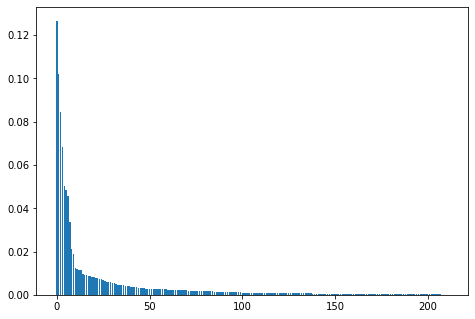

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
importance = dset.importance.tolist()
features = [i for i in range(len(importance))]
# dset.attr.tolist()

ax.bar(features,importance)
plt.show()

In [41]:
labels = np.array(data['y'])
df = data.copy()
df = df.drop('y', axis=1)

df = df[dset.attr.tolist()]

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state = seed)

print ("Train_x Shape: ",train_x.shape)
print ("Train_y Shape: ", train_y.shape)
print ("Test_x Shape: ", test_x.shape)
print ("Test_y Shape: ", test_y.shape)

models = get_models()
En_Value = models['random forest']
models.clear() 
models['random forest'] = En_Value
pred = prediction(models)
roc_scores4 = roc_auc_func(test_y, pred, scenario=4)

Train_x Shape:  (2295, 212)
Train_y Shape:  (2295,)
Test_x Shape:  (984, 212)
Test_y Shape:  (984,)
Calculating predictions..
Model: random forest
Calculating roc auc scores..
random forest             : 0.974


In [49]:
roc_scores = roc_scores[['index', 1, 2, 3, 4]]
roc_scores.loc[roc_scores['index'] == 'random forest', 5] = float(roc_scores4[4])
roc_scores['Initial Improvement'] = ((roc_scores[5] - roc_scores[1])/roc_scores[1])
roc_scores['Improvement from Previous'] = ((roc_scores[5] - roc_scores[4])/roc_scores[4])
roc_scores

,index,1,2,3,4,5,Initial Improvement,Improvement from Previous
0,svm,0.971601,0.910236,0.942566,NaN,NaN,NaN,NaN
1,knn,0.922493,0.893137,0.909187,NaN,NaN,NaN,NaN
2,naive bayes,0.844452,0.915844,0.942211,NaN,NaN,NaN,NaN
3,gradient boosting,0.960954,0.946920,0.952992,0.956734,NaN,NaN,NaN
4,random forest,0.980057,0.940680,0.971020,0.967875,0.974453,-0.005718,0.006796
5,decision tree,0.914163,0.908990,0.928620,0.913858,NaN,NaN,NaN
6,bagging,0.740382,0.736605,0.736660,NaN,NaN,NaN,NaN
